# Tutorial for Splitting Datasets

In this tutorial we investigate the concept of splitting data in multiple
partitions using pandas dataframes. The presented concepts are intensified
in a practical example, where a function is approximated using polynomial regression.

|                  |                                                                                                                                                                                                                                                                  |
|------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Requirements   	 | 	- Basic python skills                                                                                                                                                                                                                                           |
| Learning Goals 	 | 	- Understanding basics of a pandas dataframe <br/>- Concept of splitting data into multiple partitions <br/>- Various splitting strategies for dataframes. <br/>- Understanding cross-validation <br/>- Application of cross-validation in a practical use-case |
| Limitations    	 | - The tutorial only handles pandas dataframes and a numpy array in the practical use-case.                                                                                                                                                                       |


In [1]:
import numpy as np
import pandas as pd

## Splitting a Pandas Dataframe

The most basic form of a "dataset" is a simple pandas dataframe.
This is solely suitable for tabular data and only if it fits in memory.
However, we can still use this to demonstrate the basic concepts on how to split a dataset
so that a proper and reproducible evaluation is possible.

First, let's create a dummy dataframe, which has two columns: 1x dummy feature and 1x dummy labels with a ratio of 75/25 aka 25% positive labels.

In [2]:
df = pd.DataFrame({
    'feat': list(range(100)),
    'label': [0] * 75 + [1] * 25
})

print(df.head())

   feat  label
0     0      0
1     1      0
2     2      0
3     3      0
4     4      0


Generally, we start of with the concept of splitting our dataframe into two partitions: `train` and `test`.
Later, we'll introduce the concept of `train`, `validation` and `test` splits.

An easy way to split an indexable data structure into two partitions and avoid shuffling is by creating a permuted array containing indices. After determining the desired partition sizes, these indices can be used to collect data from the dataframe.
In this example we do an 80/20 split, which implies that a fifth of the full dataframe is reserved for evaluation.

A dataframe can be sliced by the `.iloc` method, whereas numpy or torch do not need this specification when performing index selection.


In [3]:
idxs = np.random.permutation(len(df))
print('Permuted indices: ', idxs)

train_size = 0.8
train_idxs = idxs[:int(len(idxs) * train_size)]
test_idxs = idxs[int(len(idxs) * train_size):]

train_df = df.iloc[train_idxs]
test_df = df.iloc[test_idxs]

Permuted indices:  [83 57  7 45 50 39 90 54 12 65 76 62 71 44 14 37 73 67  5 84 87 26 52 27
 85  0 88  9 86 31 55 20 63 15 33 79 24 78  4 21  8  6 11 42  2 82 96 58
 56 34 47 68 29 80 25 35 97 48 46 10 51 92 36 98  3 95 94 18 41 91 89 81
 72 53 60 93 70 16 32 17 13 30 75 43 99 28  1 66 61 19 40 49 59 23 38 22
 64 69 77 74]


The previous approach requires the additional `numpy` library. In cases where installation or utilization of different packages is not usable, one can also sample a predefined fraction randomly from a dataframe. Afterward, the test dataframe is obtained by checking if an index is already contained in the `train_df`. The `~` negates the boolean values returned from the `isin` function.

In [4]:
train_df = df.sample(frac=0.8)
test_df = df[~df.index.isin(train_df.index)]

## Splitting a Dataframe with scikit-learn

A more convenient approach to splitting is by using the `scikit-learn` package.
This package contains a variety of functions that simplify various splitting strategies.

The most basic variant is the `train_test_split` function. It only requires the desired size of the training dataset:

In [5]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, train_size=0.8)

print('TRAIN DATASET')
print(train_df.head())

print('TEST DATASET')
print(test_df.head())

TRAIN DATASET
    feat  label
71    71      0
8      8      0
82    82      1
81    81      1
46    46      0
TEST DATASET
    feat  label
24    24      0
2      2      0
65    65      0
67    67      0
99    99      1


As we noted in the introduction, we would like to create a reproducible splitting strategy.
In its current form the splitting function returns a different result on every execution though:

In [6]:
for i in range(3):
    train_df, test_df = train_test_split(df, train_size=0.8)
    print(f'Split {i + 1}:')
    print(train_df.head())
    print('-' * 20)

Split 1:
    feat  label
98    98      1
38    38      0
57    57      0
10    10      0
92    92      1
--------------------
Split 2:
    feat  label
42    42      0
11    11      0
81    81      1
58    58      0
85    85      1
--------------------
Split 3:
    feat  label
41    41      0
50    50      0
40    40      0
97    97      1
28    28      0
--------------------


To achieve a reproducible behavior seeding is necessary. More precisely, seeding implies providing a parameter aka *random seed*, which leads to identical random splits each time the function is executed.

In [7]:
for i in range(3):
    train_df, test_df = train_test_split(df, train_size=0.8, random_state=1337)
    print(f'Split {i + 1}:')
    print(train_df.head())
    print('-' * 20)

Split 1:
    feat  label
10    10      0
73    73      0
76    76      1
53    53      0
52    52      0
--------------------
Split 2:
    feat  label
10    10      0
73    73      0
76    76      1
53    53      0
52    52      0
--------------------
Split 3:
    feat  label
10    10      0
73    73      0
76    76      1
53    53      0
52    52      0
--------------------


A fully random split is sufficient in cases of somewhat evenly distributed labels.
In a highly unbalanced setting as it often occurs in medical settings or anomaly detection,
this can lead to unwanted side effects.

Let's imagine the following example, where our dummy dataframe only has 5% of positive labels.
If we do a random split, it could happen that our test set does not even contain a single example of our
positive class! To ensure a fair evaluation of our algorithm, the distribution of the labels in the test set
should roughly match the one of the training set.

In [8]:
df_2 = pd.DataFrame({
    'feat': list(range(100)),
    'label': [0] * 95 + [1] * 5
})

_, test_df = train_test_split(df_2, train_size=0.8, random_state=1337)
print(test_df['label'].value_counts())

label
0    20
Name: count, dtype: int64


To counter this problem, we can use **stratification**, which is a technique for partitioning a dataset into training and test sets while maintaining the same proportion of each class or target variable category in both sets as in the original dataset. This ensures that the model trained on the training set is representative of the overall distribution of the target variable and can generalize well to new data.
Stratification can be achieved by providing the `stratify` argument. The passed object should be a vector-style element of the same length as the dataframe. In our example, we stratify the split according to the labels, but this is not a necessity. A stratification criterion could also reflect certain features or criteria, e.g. matching an age distribution or ensuring balanced ethnicity.

In [9]:
_, test_df = train_test_split(
    df_2, train_size=0.8, random_state=1337, stratify=df_2['label']
)
print(test_df['label'].value_counts())

label
0    19
1     1
Name: count, dtype: int64


In our simple example the stratification results in one sample of the positive class in the test set, which reflects the previously defined ratio of 95/5 negative to positive class.

Lastly, it's worth mentioning that the `train_test_split` function does not require a pandas dataframe but - according to the documentation - allows `lists, numpy arrays, scipy-sparse matrices or pandas dataframes`.

## Defining a Training, Validation AND Test Split

When working with machine learning models, it's important to evaluate their performance on data that hasn't been seen during training. To achieve this, we can split our dataset into three parts: a training set, a validation set, and a test set.
The training set is used to train the model, the validation set is used to tune hyperparameters and make decisions about the model architecture, and the test set is used to evaluate the final performance of the model.
Scikit-learn does not provide a convenience function for doing this triplet split, but we can do so easily by ourselves:

In [10]:
from typing import Tuple, Optional


def train_val_test_split(
        df: pd.DataFrame,
        ratios: Tuple[float, float, float],
        random_state: Optional[float] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Do a train, val and test split on a dataframe."""
    assert sum(ratios) == 1., 'Splitting ratios do not add up to 1.'

    train_val_df, test_df = train_test_split(
        df, test_size=ratios[2], random_state=random_state
    )

    num_train_samples = int(len(df) * ratios[0])
    train_df, val_df = train_test_split(
        train_val_df, train_size=num_train_samples, random_state=random_state
    )
    return train_df, val_df, test_df

The above function executes the scikit learn splitting procedure twice in a row, which leads to the desired results.
It is easily extendable to work with stratification as well.
Let's try it out!

In [11]:
train_df, val_df, test_df = train_val_test_split(df, ratios=(0.7, 0.15, 0.15))

print(
    f'Train size: {len(train_df)}, val size: {len(val_df)}, test size: {len(test_df)},'
)

Train size: 70, val size: 15, test size: 15,


### Cross-validation

With our splitting procedure in place, we can advance our training setup and utilize the so-called
**cross validation**.
Cross-validation is another strategy to evaluate the performance of a predictive model.
The basic idea behind cross-validation is to split the available data into multiple sets, or "folds," and use these folds to train and test the model multiple times.
By doing this, we can get a better estimate of how the model will perform on new, unseen data.

Cross-validation typically consists of multiple phases:
    - Split the data: The first step in cross-validation is to split the available data (aka our data minus the designated test partition) into k equal-sized folds. For example, if we're using 5-fold cross-validation, we'll split the data into 5 folds, with each fold containing a fifth of the data.
    - Train the model: Next, we'll train the model using k-1 of the folds. For example, if we're using a 5-fold cross-validation, we'll train the model using 4 of the folds and leave one fold out for testing.
    - Validate the model: We'll then evaluate the model using the remaining fold that we left out in step 2. This gives us a rough  estimate of how the model will perform on the test set.
    - Repetition: The training and validation steps are repeated until each fold was once utilized as validation set. This will give us k estimates of how the model will perform on new data.
    - Final Evaluation: Evaluate the performance: Finally, we'll evaluate the performance of the model by aggregating the obtained metrics from each fold.

Following this procedure gives us a sound estimate whether our current hyperparameters lead to a model that generalizes well.
A depiction of cross-validation can be found in the [sklearn documentation](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png), which visualizes the described steps in a simplified fashion.

Note that in machine learning the ultimate goal is to create a model, which has a high generalization factor and not to overfit on the test set. Cross-validation allows to perform hyperparameter search without specifically investigating the fit on the unseen test data.
In current deep learning literature you will notice that you won't find this concept very often. This has multiple reasons.
First, training large models is time and resource intensive. Doing a large hyperparameter search and fitting a model for multiple folds is often simply not in the budget.
Second, a lot of research tries to beat state-of-the-art on some benchmarks like CIFAR10 or Imagenet.
The goal is literally to maximize performance on the test set without regarding a classic evaluation scheme.
This leads to hyperparameters that are specifically tweaked to the test set, which is in contrast to the points we discussed here previously.

One important last thing to note is that cross-validation is typically used for evaluating model performance during development.
Once the desired performance of the model is achieved, it is trained on all folds and then used to make predictions on new data (aka our real test set).

To do cross-validation in python, the scikit-learn library provides a few utilities like `KFold`:

In [12]:
from sklearn.model_selection import KFold

# First extract our dedicated test set
train_val_df, test_df = train_test_split(df, train_size=0.8)

# Create a KFold instance
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

# Iterate over the respective folds
for i, (train_idxs, val_idxs) in enumerate(kf.split(train_val_df)):
    print(
        f'Fold {i}, train size: {len(train_idxs)}, validation size: {len(val_idxs)}'
    )
    print(f'Validation indices: {val_idxs}')
    print('-' * 20)

    train_df = train_val_df.iloc[train_idxs]
    val_df = train_val_df.iloc[val_idxs]

    # --> FIT AND EVALUATE MODEL <--

Fold 0, train size: 64, validation size: 16
Validation indices: [ 3  4  5  6  8 11 19 28 40 46 52 65 66 69 78 79]
--------------------
Fold 1, train size: 64, validation size: 16
Validation indices: [ 7 15 18 22 27 29 30 34 41 53 54 57 64 67 70 76]
--------------------
Fold 2, train size: 64, validation size: 16
Validation indices: [ 0 12 13 21 23 24 36 38 39 42 45 47 58 60 62 72]
--------------------
Fold 3, train size: 64, validation size: 16
Validation indices: [ 1  9 20 31 33 35 37 44 49 55 59 61 63 68 71 75]
--------------------
Fold 4, train size: 64, validation size: 16
Validation indices: [ 2 10 14 16 17 25 26 32 43 48 50 51 56 73 74 77]
--------------------


Note that the above workflow does not directly split the dataframe in the for-loop iteration, but returns **indices**.

In the following we will do a small practical example that puts the previously proposed strategies to good use!

## Practical Example: Cross-validation and Regression

For our practical example, we would like to approximate a function.
More precisely, we showcase how you could use the cross validation utility not only to find the best
hyperparameters, but to use (or abuse) it as a simple resampling strategy to do model ensembling.
We decide to go for an arbitrary polynomial function, which we define in the following.

In [13]:
def func(x: np.ndarray) -> np.ndarray:
    return 1 - 0.8 * x + 0.8 * x ** 2 + 0.3 * x ** 3 - 0.4 * x ** 4

Our target function can be plotted using `matplotib` in combination with the `linspace` function.
Here, `linspace` creates a vector with 100 evenly spaced numbers between -2 and 2.

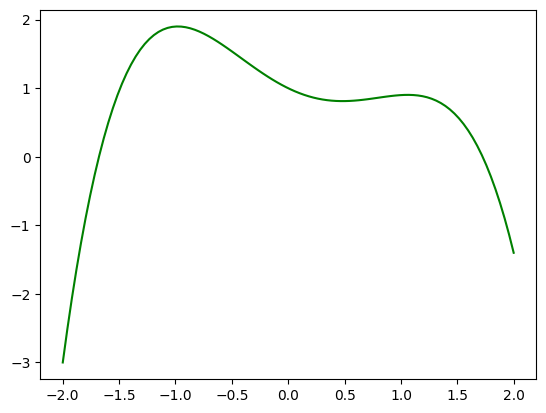

In [14]:
import matplotlib.pyplot as plt

x = np.linspace(-2, 2, 100)
plt.plot(x, func(x), c='g')
plt.show()

We are not done with creating our dummy dataset yet.
The dataset itself is sampled by randomly selecting inputs for our function (`x` axis)
and subsequently putting some noise on the observed true response `y`.

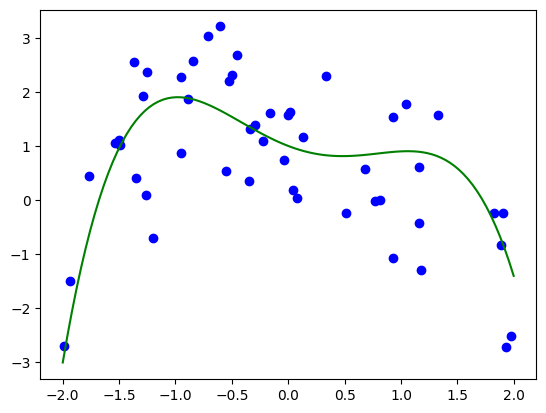

In [15]:
num_samples = 50
noise_variance = 1

# Set global seed for reproducibility.
np.random.seed(1337)

# Sample random x values and create a noised response.
x = np.random.uniform(-2, 2, size=(num_samples, 1))
y = func(x) + noise_variance * np.random.normal(size=(num_samples, 1))
plt.scatter(x, y, c='b')

# Plot the function with the function including the noised samples.
x_true = np.linspace(-2, 2, 100)
plt.plot(x_true, func(x_true), c='g')
plt.show()

As it can be seen in the graph, it gets increasingly difficult to estimate the base function from the few samples
the more noise is added.

Nevertheless, let's reserve a few (noised) data points as test set.

In [16]:
train_val_x, test_x, train_val_y, test_y = train_test_split(
    x, y, train_size=0.8, random_state=1337
)

For our model, we make a bold assumption: We already observed from the training data that
the true function must be a polynomial of degree four!

Thus, the model of choice is a polynomial regression.
In scikit-learn this is realized by transforming the input features with `PolynomialFeatures`
and then utilizing `LinearRegression`.
For example with a degree of `4` and the option `include_bias=True` our univariate input $x$ would be
transformed into a vector that contains \[1 $x$ $x^2$ $x^3$ $x^4$ \].

In the following, we fit the polynomial regression model on all data but the test data.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Choose the degree of the polynomial.
degrees = 4
# Transform into polynomial features.
poly = PolynomialFeatures(degree=degrees, include_bias=True)
x_poly = poly.fit_transform(train_val_x)

# Fit linear regression on polynomial features.
lr = LinearRegression()
lr.fit(x_poly, train_val_y)

LinearRegression()

As usual the estimated coefficients can be checked.

In [18]:
print('COEFFICIENTS:', lr.coef_[0])

COEFFICIENTS: [ 0.         -0.94456601  0.36214103  0.26918903 -0.30352206]


Next, the mean squared error for our reserved test set and for the actual true function is computed.

In [19]:
test_x_poly = poly.fit_transform(test_x.reshape(-1, 1))
print('TEST MSE:', mean_squared_error(test_y, lr.predict(test_x_poly)))

x_true_poly = poly.fit_transform(x_true.reshape(-1, 1))
print('TRUE MSE:', mean_squared_error(func(x_true), lr.predict(x_true_poly)))

TEST MSE: 0.8246164617230851
TRUE MSE: 0.10454374821283999


Not that bad! Additionally the approximated function is plotted (red):

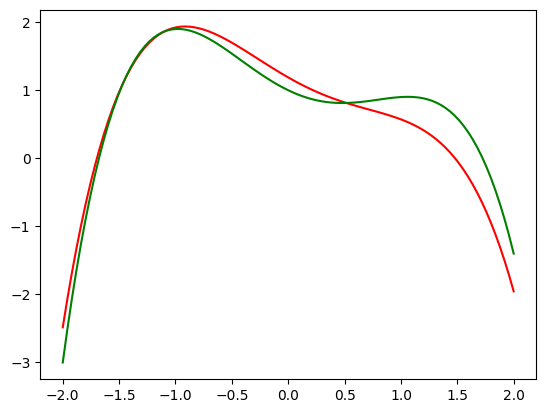

In [20]:
plt.plot(x_true, lr.predict(x_true_poly), c='r')
plt.plot(x_true, func(x_true), c='g')
plt.show()

That is not too far off, but can we do better?

In the next approach, the training dataset is splitted using cross-validation.
From each fold, one `LinearRegression` object is obtained, which was fitted on a
subset of the full training data.

Fold 0
COEFFICIENTS: [ 0.         -0.88473208  0.37507706  0.29932773 -0.26564637]
TEST MSE: 0.7474878470427194
TRUE MSE: 0.04483478636205592
--------------------
Fold 1
COEFFICIENTS: [ 0.         -0.71267352  0.41650921  0.2097751  -0.33446362]
TEST MSE: 1.0483710763805327
TRUE MSE: 0.0873304298547162
--------------------
Fold 2
COEFFICIENTS: [ 0.         -1.27840031  0.65079621  0.37699189 -0.39252634]
TEST MSE: 0.9284295612258451
TRUE MSE: 0.14747381533776652
--------------------
Fold 3
COEFFICIENTS: [ 0.         -1.12556264  0.11276866  0.31470042 -0.24424964]
TEST MSE: 0.7453230866438626
TRUE MSE: 0.24353934262509647
--------------------
Fold 4
COEFFICIENTS: [ 0.         -0.8369903   0.27945664  0.23663674 -0.28017851]
TEST MSE: 0.8228037018088775
TRUE MSE: 0.10782273176383166
--------------------


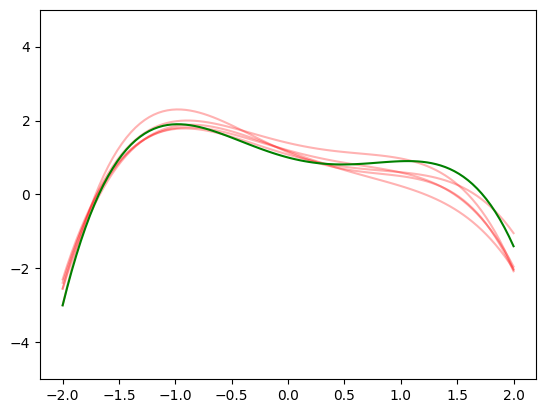

In [21]:
degrees = 4
num_folds = 5

lrs = []

kf = KFold(n_splits=num_folds)
kf_idxs = kf.split(train_val_x, train_val_y)
for i, (train_idxs, val_idxs) in enumerate(kf_idxs):
    # Partition train and validation data
    train_x = train_val_x[train_idxs]
    train_y = train_val_y[train_idxs]
    val_x = train_val_x[val_idxs]
    val_y = train_val_y[val_idxs]

    # Fit LR on fold
    poly = PolynomialFeatures(degree=degrees, include_bias=True)
    x_poly = poly.fit_transform(train_x)
    lr = LinearRegression()
    lr.fit(x_poly, train_y)

    # Save fitted model for later
    lrs.append(lr)

    # Print coefficients and performance on test set
    print('Fold', i)
    print('COEFFICIENTS:', lr.coef_[0])
    print('TEST MSE:', mean_squared_error(test_y, lr.predict(test_x_poly)))
    print('TRUE MSE:', mean_squared_error(func(x_true), lr.predict(x_true_poly)))
    print('-' * 20)

    # Add plot of predicted function
    plt.plot(x_true, lr.predict(x_true_poly), c='r', alpha=0.3)

plt.plot(x_true, func(x_true), c='g')
ax = plt.gca()
ax.set_ylim([-5, 5])
plt.show()

The above plot shows the base function in green as usual but also contains the approximated function
from each fold. Changing the input data slightly, as we did over the folds -- especially in a low data and high noise regime -- results in variable outputs.

We can abuse the fact that each fold estimates a different optimal model and combine all estimators
in a single on. In our case we make a prediction with every model and average them.
That's called **ensembling**. A variety of strategies exist on how to combine ensemble members,
but doing a simple mean is probably the most adopted one.

A function is added, which takes an input array plus a list of `LinearRegression` objects and
returns the averaged prediction across the ensemble members.

In [22]:
from typing import List


def predict_ensemble(
        x: np.ndarray, degrees: int, lrs: List[LinearRegression]
) -> np.ndarray:
    poly = PolynomialFeatures(degree=degrees, include_bias=True)
    x_poly = poly.fit_transform(x.reshape(-1, 1))

    preds = [lr.predict(x_poly) for lr in lrs]
    return np.mean(np.concatenate(preds, axis=1), axis=1)

Finally, let's check whether we good closer to the true function using our small ensemble method:

TEST MSE: 0.07379802224158301
TRUE MSE: 0.08731119426878277


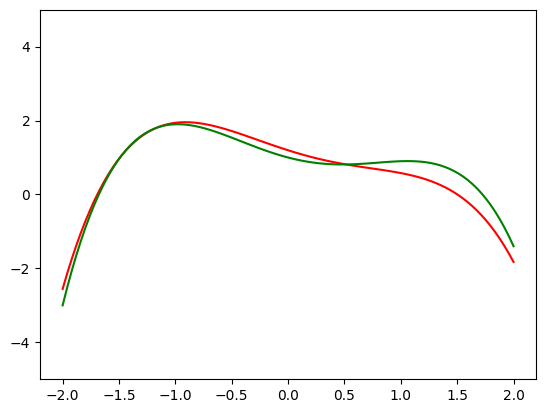

In [23]:
# Predict with ensemble on test data.
y_ens = predict_ensemble(test_x, degrees=4, lrs=lrs)
y_true_approx = predict_ensemble(x_true, degrees=4, lrs=lrs)

print('TEST MSE:', mean_squared_error(func(test_x), y_ens))
print('TRUE MSE:', mean_squared_error(func(x_true), y_true_approx))

plt.plot(x_true, y_true_approx, c='r')
plt.plot(x_true, func(x_true), c='g')
ax = plt.gca()
ax.set_ylim([-5, 5])
plt.show()

Indeed! Our final MSE is lower than in the single split strategy and the plotted function seems
to be closer to the original.